# Lab: Pokémon Data Classification

## Objective
This notebook demonstrates how to classify Pokémon as legendary or not using two machine learning models:
- Logistic Regression
- Multi-Layer Perceptron (MLP)

We will compare the performance of both models using metrics such as accuracy, precision, recall, F1-score, and AUC-ROC.

## Step 1: Load and Explore the Dataset

In [31]:
# Imports 
import pandas as pd
import numpy as np

# Load the Pokémon dataset
pokemon_data =  pd.read_csv('pokemon.csv')# Your code

# Display the first few rows
pokemon_data.head(5)

,name,deck_no,attack,defense,sp_attack,sp_defense,speed,capture_rt,total_bs,type,gen,legendary
0,Bulbasaur,1,49,49,65,65,45,45,318,grass,1,0
1,Ivysaur,2,62,63,80,80,60,45,405,grass,1,0
2,Venusaur,3,100,123,122,120,80,45,625,grass,1,0
3,Charmander,4,52,43,60,50,65,45,309,fire,1,0
4,Charmeleon,5,64,58,80,65,80,45,405,fire,1,0


## Step 2: Data Preprocessing
### 2.1 Feature Engineering

### <span style="color:red">Please create a derived feature: sp_attack_to_sp_defense_ratio, Target is Legendary</span>. 

In [33]:
# Create a derived feature: sp_attack_to_sp_defense_ratio
pokemon_data['sp_attack_to_sp_defense_ratio'] = pokemon_data['attack'] / pokemon_data['defense']
# Select all features + derived  
# target: Legendary 
features = ['deck_no', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'capture_rt',
            'total_bs', 'type', 'gen', 'sp_attack_to_sp_defense_ratio']
target = 'legendary'
X = pokemon_data[features]
y = pokemon_data[target]

### 2.2 Data Transformation Using ColumnTransformer

In [35]:
# Imports 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
# Categorical and numerical columns
categorical = ['type']
numerical = [col for col in features if col not in categorical]
x = pokemon_data[numerical]
# MaxAbsScaler as scaling method
maxAbsScaler = MaxAbsScaler()
xMax = pd.DataFrame(maxAbsScaler.fit_transform(x), columns=numerical)
numericTransformer = maxAbsScaler
# OneHotEncoder used to convert categorical data to numerical format
categoricalTransformer = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numericTransformer, numerical),
        ('cat', categoricalTransformer, categorical)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num', MaxAbsScaler(),
                                 ['deck_no', 'attack', 'defense', 'sp_attack',
                                  'sp_defense', 'speed', 'capture_rt',
                                  'total_bs', 'gen',
                                  'sp_attack_to_sp_defense_ratio']),
                                ('cat', OneHotEncoder(), ['type'])])

### Prepare the training data

In [51]:
from sklearn.model_selection import train_test_split

# Transform the data
xTransformed = preprocessor.fit_transform(X)

# Train-test split
# Step 1: First train-test split to create training and temporary sets
# X_transformed: Preprocessed feature data
# y: Target labels
# test_size=0.3: Reserve 30% of the data for validation and test sets
# random_state=42: Ensures reproducibility of the splits
# stratify=y: Maintains the class distribution in the split
xTrain, xTemp, yTrain, yTemp = train_test_split(
    xTransformed, y, test_size = 0.3, random_state = 42, stratify = y
)

In [53]:
# Prepare data
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size = 0.5, random_state = 42, stratify = yTemp)

#Print X_train and X_test
xTrain[:2], xTest[:2]

(array([[0.09862672, 0.35135135, 0.2826087 , 0.20618557, 0.17391304,
         0.08333333, 0.74509804, 0.40384615, 0.14285714, 0.22222222,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        ],
        [0.30836454, 0.45405405, 0.30434783, 0.33505155, 0.30434783,
         0.28333333, 0.17647059, 0.52564103, 0.28571429, 0.26666667,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        ]]),
 array([[0.72908864, 0.51351351, 0.36956522, 0.56701031, 0.41304348,
         0.43888889, 0.17647059, 0.68589744, 0.71428571, 0.24836601,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         

## Step 3: Logistic Regression

In [59]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

# Build Logistic Regression model
logModel = LogisticRegression(max_iter = 300, random_state = 42)
logModel.fit(xTrain, yTrain)

# Train Logistic Regression
yProbLog = logModel.predict_proba(xVal)[:, 1]
aucValLog = roc_auc_score(yVal, yProbLog)
yPredLog = logModel.predict(xVal)
accuracyScore = accuracy_score(yVal, yPredLog)

# Use AUC and accuracyScore to evaluate model
print("<Ruby> + Logistic Regression - Validation Performance:")
print(classification_report(yVal, yPredLog))
print(f"Validation AUC: {aucValLog:.4f}")
print(f"Validation accuracy: {accuracyScore:.4f}")

<Ruby> + Logistic Regression - Validation Performance:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       110
           1       1.00      0.60      0.75        10

    accuracy                           0.97       120
   macro avg       0.98      0.80      0.87       120
weighted avg       0.97      0.97      0.96       120

Validation AUC: 0.9709
Validation accuracy: 0.9667


## Step 4: Multi-Layer Perceptron (MLP)

In [61]:
from sklearn.neural_network import MLPClassifier

# Build Multi-Layer Perceptron model
# Hidden layer: 8 weights and 4 biases, activation: relu, iteration : 500
mlpModel = MLPClassifier(hidden_layer_sizes = (2, 2), activation = 'relu', max_iter = 500, random_state = 42)
mlpModel.fit(xTrain, yTrain)
# Train and evaluate MLP Classifier
yPredMLP = mlpModel.predict(xVal)
mlpAccuracy = accuracy_score(yVal, yPredMLP)
yProbMLP = mlpModel.predict_proba(xVal)[:, 1]
aucValMLP = roc_auc_score(yVal, yProbMLP)
print("<Ruby> + MLP Classifier - Validation Performance:")
print(classification_report(yVal, yPredMLP))
print(f"Validation AUC: {aucValMLP:.4f}")
print(f"Validation accuracy: {mlpAccuracy:.4f}")

<Ruby> + MLP Classifier - Validation Performance:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       110
           1       0.00      0.00      0.00        10

    accuracy                           0.92       120
   macro avg       0.46      0.50      0.48       120
weighted avg       0.84      0.92      0.88       120

Validation AUC: 0.9650
Validation accuracy: 0.9167


C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-def

## Step 5: Comparison of Models - Training Loss Curve

### Manually record the loss of logistic regression

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
# Record loss of logistic regression
logModel = LogisticRegression(
    max_iter = 1,
    solver = 'saga',
    random_state = 42,
    warm_start = True
)
# To store the loss values
loss_curve = []
# Train the model incrementally
for i in range(1, 501):
    logModel.fit(xTrain, yTrain)
    yTrainProb = logModel.predict_proba(xTrain)
    loss = log_loss(yTrain, yTrainProb)
    loss_curve.append(loss)


C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rubyr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

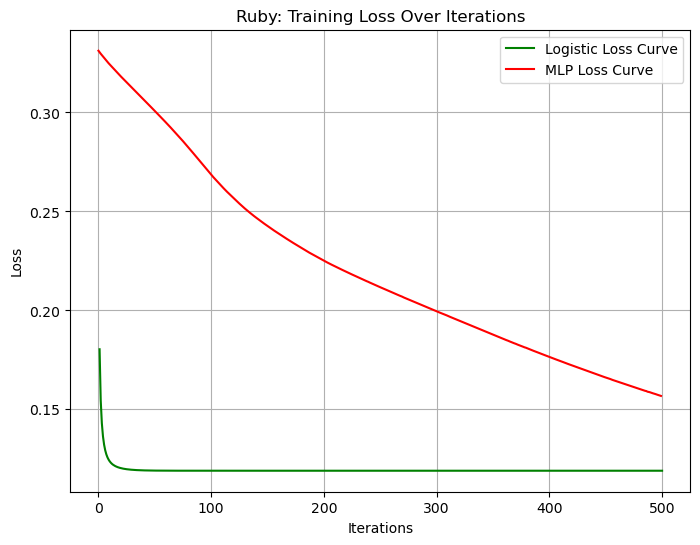

In [69]:
# Extract loss during MLP training
mlpLossCurve = mlpModel.loss_curve_
logicLoss = loss_curve

# Plot the loss difference during MLP training and Logistic
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(logicLoss) + 1), logicLoss, label = "Logistic Loss Curve", color = 'green')
plt.plot(mlpLossCurve, label = "MLP Loss Curve", color = 'red)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Ruby: Training Loss Over Iterations")
plt.grid()
plt.legend()
plt.show()

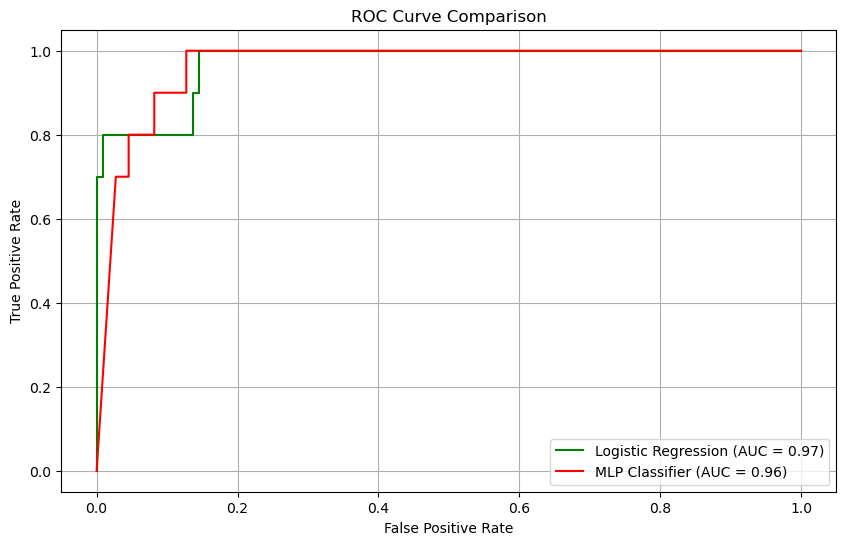

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# Plot ROC Curve Comparison
fprLog, tprLog, _ = roc_curve(yVal, yProbLog)
fprMLP, tprMLP, _ = roc_curve(yVal, yProbMLP)
# Plot ROC curves
plt.figure(figsize = (10, 6))
plt.plot(fprLog, tprLog, label = f'Logistic Regression (AUC = {aucValLog:.2f})', color = 'green')
plt.plot(fprMLP, tprMLP, label = f'MLP Classifier (AUC = {aucValMLP:.2f})', color = 'red')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.grid()
plt.show()

## Step 6: Visualization of Predictions and Confusion Matrices

### 6.1 Actual vs Predicted Results

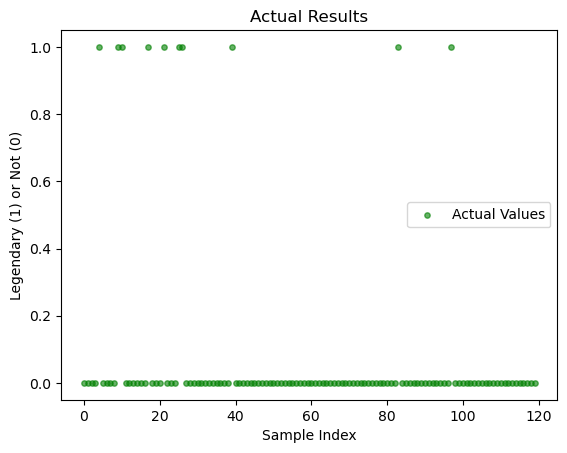

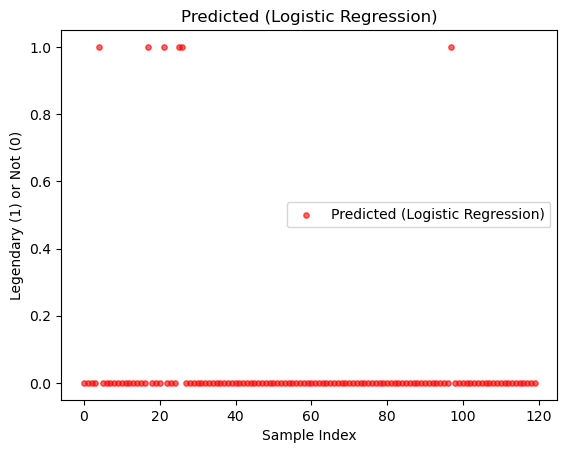

In [73]:
# Plot the Actual data and Predicted for Logistic and MLP model
plt.scatter(range(len(yVal)), yVal, color = 'green', alpha = 0.6, label = "Actual Values", s = 15)
plt.title("Actual Results")
plt.xlabel("Sample Index")
plt.ylabel("Legendary (1) or Not (0)")
plt.legend()
plt.show()
plt.scatter(range(len(yVal)), yPredLog, color = 'red', alpha = 0.6, label = "Predicted (Logistic Regression)", s = 15)
plt.title("Predicted (Logistic Regression)")
plt.xlabel("Sample Index")
plt.ylabel("Legendary (1) or Not (0)")
plt.legend()
plt.show()

### Confusion Matrices

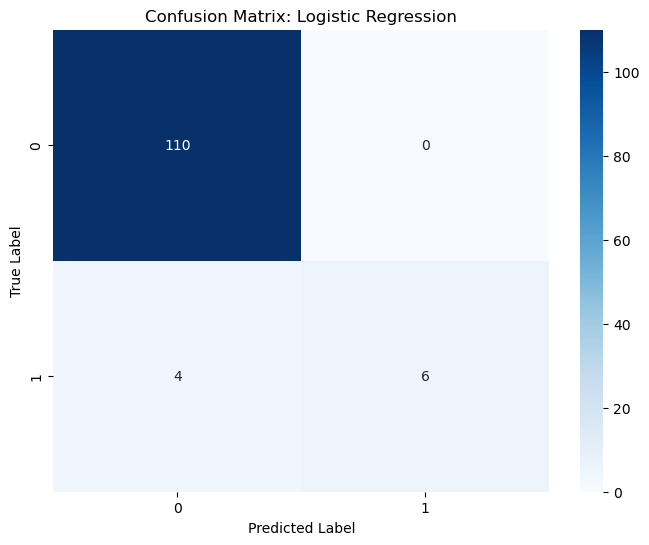

In [75]:
# Imports
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Plot Logistic Regression
cmLog = confusion_matrix(yVal, yPredLog)
plt.figure(figsize = (8, 6))
sns.heatmap(cmLog, annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

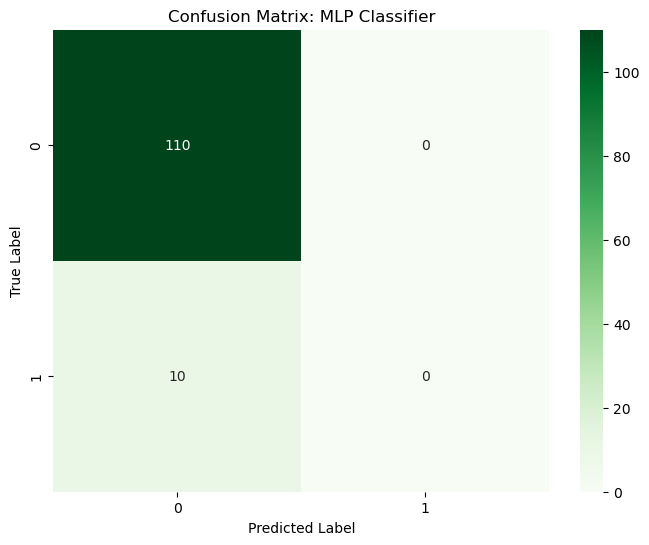

In [77]:
# Plot MLP
cmMLP = confusion_matrix(yVal, yPredMLP)
plt.figure(figsize = (8, 6))
sns.heatmap(cmMLP, annot = True, fmt = "d", cmap = "Greens")
plt.title("Confusion Matrix: MLP Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
